In [1]:
"""
(C) Yu-Hao Chen (2023)

This is the accompanying code for the paper
'Making the zeroth-order process fidelity independent of state preparation and measurement errors'
Yu-Hao Chen, Renata Wong, Hi-Sheng Goan
"""



import numpy as np
import matplotlib.pyplot as plt
import itertools
from qutip import sigmax, sigmay, sigmaz, qeye, Qobj, tensor, ket2dm
from qutip.measurement import measure_observable

from qutip import (Qobj, basis, gate_expand_1toN, qeye,
                   sigmax, sigmay, sigmaz, snot, tensor, rx, ry, rz, cnot, cphase)

from scipy import linalg

import copy
import itertools
from typing import List, Union

from qiskit import IBMQ, Aer, execute, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.utils import QuantumInstance 

from qiskit.circuit import Parameter
from qiskit.compiler import transpile


# Import general libraries (needed for functions)
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import display

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits
import qiskit.quantum_info as qi

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from qiskit.opflow import I, X, Y, Z
from qiskit_aer import QasmSimulator

backend = AerSimulator.from_backend(FakeParis())



# Packages related to state preparation and measurement (SPAM) errors
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import Kraus, SuperOp, DensityMatrix, state_fidelity, process_fidelity, average_gate_fidelity
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


from typing import List, Optional, Union
from warnings import warn
from numpy.random import RandomState


from qiskit.quantum_info import Clifford
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.extensions import RXGate, XGate, CXGate

from qiskit.circuit import QuantumCircuit, Instruction
from qiskit.quantum_info import Clifford, CNOTDihedral
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.transpiler.passes import RemoveBarriers





def get_parity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity


def expectation_value_from_counts(counts, nqubits, nshots):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if get_parity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if get_parity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots


#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error


depolarizing_model = NoiseModel()

# add depolarizing noise to 3 qubits u gates
error_d = depolarizing_error(0.12, 1) # 0.018
# 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12]
error_d_cx = depolarizing_error(0.12, 2)
#depolarizing_model.add_all_qubit_quantum_error(error_d, "reset")
#depolarizing_model.add_all_qubit_quantum_error(error_d, "u")
#depolarizing_model.add_all_qubit_quantum_error(error_d, "measure")
depolarizing_model.add_all_qubit_quantum_error(error_d_cx, "cz")
noise_simulator = AerSimulator(noise_model=depolarizing_model)
noise_simulator

Initial_noise = SuperOp(error_d).to_instruction()
Initial_noise.label = "noise"

C:\Users\User\AppData\Local\Temp\ipykernel_16948\2590933055.py:46: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb
C:\Users\User\AppData\Local\Temp\ipykernel_16948\2590933055.py:55: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, X, Y, Z


In [2]:
'''
This is the main code for the 0 fidelity protocol
'''
nqubits = 3

INPUT_STATE = [[0, 0, 0], [2 * np.arccos(np.sqrt(1/3)), 0, 0], [2 * np.arccos(np.sqrt(1/3)), 2 * np.pi/3, 0],
                     [2 * np.arccos(np.sqrt(1/3)), 4 * np.pi/3, 0]]


def generate_circuits_SPAM(nqubits, Initial_noise, theta):
    
    
    params = ParameterVector('p', 2 * 3 * nqubits)
    
    phi = Parameter("phi")
    lamb = Parameter("lamb")
    
    
    half_len_params = int(len(params)/2)

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')
    
    circuits = []
    
    inputs = [''.join(i) for i in itertools.product('0123', repeat=nqubits)]
    paulis = [''.join(i) for i in itertools.product('IXYZ', repeat=nqubits)]
    
    # generating circuits for each combination of input state and Pauli operator
    
    for digit_string in inputs:
        for pauli in paulis:

            qc = QuantumCircuit(qr, cr)

            # append input states
            for digit, qubit in zip(digit_string, range(qc.num_qubits)):
                qc.u(INPUT_STATE[int(digit)][0], INPUT_STATE[int(digit)][1], INPUT_STATE[int(digit)][2], qubit)
            
            
            # for state preparation error
            #for n in range(nqubits):
            #    degrees = np.random.normal(0, np.sqrt(5), size=(1, 3))
                #qc.u(2*5*(np.pi)/180, 5*(np.pi)/180, 5*(np.pi)/180, n)
            qc.barrier()

            # the channel for zero-fidelity
            for k in range(2):
                for i in range(nqubits-1):
                    qc.cx(i, i+1)

            qc.barrier()


            # append Paulis
            for single_pauli, qubit in zip(pauli, range(qc.num_qubits)):
                if single_pauli == 'I':
                    #pass
                    qc.reset(qubit)
                if single_pauli == 'X':
                    qc.h(qubit)
                if single_pauli == 'Y':
                    qc.h(qubit)
                    qc.p(-np.pi/2, qubit)
                if single_pauli == 'Z':
                    qc.id(qubit)

            qc.barrier()

            qc.measure(qr, cr)

            circuits.append(qc)
        
    return circuits

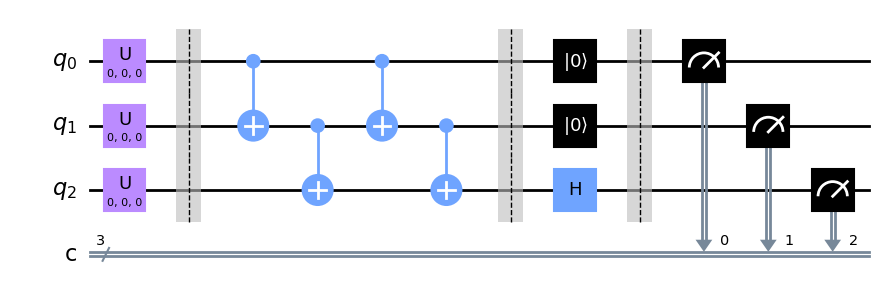

In [3]:
def generate_circuits(nqubits):
    
    params = ParameterVector('p', 2 * 3 * nqubits)
    half_len_params = int(len(params)/2)

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')
    
    circuits = []
    
    inputs = [''.join(i) for i in itertools.product('0123', repeat=nqubits)]
    paulis = [''.join(i) for i in itertools.product('IXYZ', repeat=nqubits)]
    
    # generating circuits for each combination of input state and Pauli operator
    
    for digit_string in inputs:
        for pauli in paulis:

            qc = QuantumCircuit(qr, cr)

            # append input states
            for digit, qubit in zip(digit_string, range(qc.num_qubits)):
                qc.u(INPUT_STATE[int(digit)][0], INPUT_STATE[int(digit)][1], INPUT_STATE[int(digit)][2], qubit)
            

            qc.barrier()


            # the channel for zero-fidelity
            for k in range(2):
                for i in range(nqubits-1):
                    qc.cx(i, i+1)

            qc.barrier()



            # append Paulis
            for single_pauli, qubit in zip(pauli, range(qc.num_qubits)):
                if single_pauli == 'I':
                    #pass
                    qc.reset(qubit)
                if single_pauli == 'X':
                    qc.h(qubit)
                if single_pauli == 'Y':
                    qc.h(qubit)
                    qc.p(-np.pi/2, qubit)
                if single_pauli == 'Z':
                    qc.id(qubit)

            qc.barrier()
            qc.measure(qr, cr)

            circuits.append(qc)
        
    return circuits
generate_circuits(nqubits)[1].draw("mpl")

In [4]:
# Calculating the zero-fidelity

def expectation_values(nqubits, params, Initial_noise, theta, noisy=False):
    
    if noisy == True:
        #backend = noise_simulator  #FakeManilaV2()
        noise_simulator = AerSimulator(noise_model=noise_model)
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits_SPAM(nqubits, Initial_noise, theta)#generate_circuits(nqubits, Initial_noise)

        for circuit in circuits:

            #circuit.assign_parameters(theta, inplace=True)
            backend = transpile(circuit, noise_simulator)
            results = noise_simulator.run(backend).result()
            #results = execute(circuit, backend=backend).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)
        
    if noisy == False:
        backend = QasmSimulator(method='statevector') #Aer.get_backend('qasm_simulator')
    
        nshots = 1024

        Counts = []
        expvals = []
        circuits = generate_circuits(nqubits)

        for circuit in circuits:

            #circuit.assign_parameters(params, inplace=True)
            results = execute(circuit, backend, shots=nshots).result()
            counts = results.get_counts(circuit)
            expval = expectation_value_from_counts(counts, nqubits, nshots)
            Counts.append(counts)
            expvals.append(expval)

    return expvals



Dep_strength_cx = np.linspace(0, 0.18, 10) # the strength of depolarizing error
theta = np.linspace(0, 18, 10)
SPAM_dep = []
for i in range(len(Dep_strength_cx)):
    noise_model = NoiseModel()
    
    readout_1 = 0.03
    readout_0 = 0.05
    readout_error = ReadoutError([[1-readout_1, readout_1], [readout_0, 1-readout_0]])
    
    dep = depolarizing_error(Dep_strength_cx[i], 2)

    noise_model.add_all_qubit_quantum_error(dep, "cx")
    noise_model.add_readout_error(readout_error, [0])
    noise_model.add_readout_error(readout_error, [1])
    noise_model.add_readout_error(readout_error, [2])
    nqubits = 3

    d = 2**nqubits
    params = np.linspace(0, 0, 6 * nqubits)

    Fid_lises = []

    expvals_noisy = expectation_values(nqubits, params, Initial_noise, 0, True)
    expvals_noiseless = expectation_values(nqubits, params, Initial_noise, 0, False)

    zero_fidelity = 0.0
    for expval_noisy, expval_noiseless in zip(expvals_noisy, expvals_noiseless):
        zero_fidelity += (expval_noisy * expval_noiseless)
        #print('{}, {}'.format(expval_noisy, expval_noiseless))

    zero_fidelity /= d**3
    SPAM_dep.append(zero_fidelity)
SPAM_dep

[0.8882536739110947,
 0.8323461413383484,
 0.7835472449660301,
 0.7336888536810875,
 0.6881969198584557,
 0.6446514874696732,
 0.6059607565402985,
 0.5651955455541611,
 0.5290728360414505,
 0.4975413605570793]